# DCT Steganography - Data Embedding in Images
This notebook hides a secret message inside an image using the **Discrete Cosine Transform (DCT)** technique.
Run each block (cell) in order, from top to bottom.

In [24]:
import sys
!{sys.executable} -m pip install jpegio

In [25]:
# ============================================================
# BLOCK 1: Install required libraries
# Run this block ONCE the first time you set up the environment
# ============================================================
import sys
!{sys.executable} -m pip install numpy opencv-python scipy Pillow

In [26]:
# ============================================================
# BLOCK 2: Import libraries
# ============================================================
import numpy as np                        # numerical operations
import cv2                                # image read/write
from scipy.fftpack import dct, idct       # DCT and inverse DCT
from PIL import Image                     # image display inside notebook
import matplotlib.pyplot as plt           # plotting
import os
import jpegio
print(dir(jpegio))

print('All libraries imported successfully!')

['ComponentInfo', 'DECOMPRESSED', 'DecompressedJpeg', 'Flag', 'ZIGZAG_DCT_1D', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'componentinfo', 'decompressedjpeg', 'flags', 'io', 'read', 'write']
All libraries imported successfully!


In [27]:
# ============================================================
# BLOCK 3 (v4): Constants and helpers
# ============================================================
import numpy as np
import cv2
from scipy.fftpack import dct, idct

# We embed by comparing TWO coefficients instead of using remainder.
# Bit=1: force coeff_A > coeff_B by at least DELTA
# Bit=0: force coeff_A < coeff_B by at least DELTA
# This survives uint8 rounding because we only care about which is BIGGER,
# not the exact value.
COEFF_A = (4, 5)   # first coefficient position
COEFF_B = (5, 4)   # second coefficient position
DELTA = 25         # minimum difference to enforce between the two coefficients

def text_to_bits(text):
    bits = []
    for char in text:
        byte = ord(char)
        for i in range(7, -1, -1):
            bits.append((byte >> i) & 1)
    return bits

def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) < 8:
            break
        value = int(''.join(str(b) for b in byte), 2)
        chars.append(chr(value))
    return ''.join(chars)

def apply_dct_block(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def apply_idct_block(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

print('Block 3 v4 ready. DELTA =', DELTA)

Block 3 v4 ready. DELTA = 25


In [28]:
# ============================================================
# BLOCK 4 (v5): Crop to multiple of 8, then embed
# ============================================================

def embed_message(image_path, message, output_path):

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f'Cannot open image: {image_path}')

    img = np.clip(img, 0, 255).astype(np.uint8)

    # Crop width and height to nearest multiple of 8
    # This eliminates any leftover pixel columns/rows that cause block misalignment
    h, w = img.shape[:2]
    new_h = (h // 8) * 8
    new_w = (w // 8) * 8
    img = img[0:new_h, 0:new_w]
    print(f'Cropped image from {w}x{h} to {new_w}x{new_h}')

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(img_ycrcb)
    Cr = Cr.astype(np.uint8)
    Cb = Cb.astype(np.uint8)
    Y  = Y.astype(np.float64)

    full_message = message + '\x00'
    bits = text_to_bits(full_message)
    total_bits = len(bits)

    height, width = Y.shape
    blocks_v = height // 8
    blocks_h = width // 8
    total_blocks = blocks_v * blocks_h

    print(f'Total blocks      : {total_blocks}')
    print(f'Bits to embed     : {total_bits}')
    print(f'Max characters    : {total_blocks // 8}')

    if total_bits > total_blocks:
        raise ValueError(f'Message too long! Max chars: {total_blocks // 8}')

    ra, ca = COEFF_A
    rb, cb = COEFF_B
    bit_index = 0

    for row in range(blocks_v):
        for col in range(blocks_h):
            if bit_index >= total_bits:
                break

            r = row * 8
            c = col * 8
            block = Y[r:r+8, c:c+8].copy()
            dct_block = apply_dct_block(block)

            a = dct_block[ra, ca]
            b = dct_block[rb, cb]
            mid = (a + b) / 2.0

            if bits[bit_index] == 1:
                dct_block[ra, ca] = mid + DELTA / 2
                dct_block[rb, cb] = mid - DELTA / 2
            else:
                dct_block[ra, ca] = mid - DELTA / 2
                dct_block[rb, cb] = mid + DELTA / 2

            Y[r:r+8, c:c+8] = apply_idct_block(dct_block)
            bit_index += 1

    Y_uint8 = np.clip(Y, 0, 255).astype(np.uint8)
    stego_ycrcb = cv2.merge([Y_uint8, Cr, Cb])
    stego_bgr   = cv2.cvtColor(stego_ycrcb, cv2.COLOR_YCrCb2BGR)

    ok = cv2.imwrite(output_path, stego_bgr)
    print(f'Saved: {output_path}  |  Success: {ok}')
    return stego_bgr

print('embed_message() v5 defined.')

embed_message() v5 defined.


In [29]:
# ============================================================
# BLOCK 5 (v5): Extract — no changes needed here, just clean
# ============================================================

def extract_message(stego_image_path):

    img = cv2.imread(stego_image_path)
    if img is None:
        raise FileNotFoundError(f'Cannot open image: {stego_image_path}')

    # The stego image is already cropped to multiple of 8 from embedding
    # so no cropping needed here
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, _, _ = cv2.split(img_ycrcb)
    Y = Y.astype(np.float64)

    height, width = Y.shape
    blocks_v = height // 8
    blocks_h = width // 8

    ra, ca = COEFF_A
    rb, cb = COEFF_B
    bits = []

    for row in range(blocks_v):
        for col in range(blocks_h):
            r = row * 8
            c = col * 8
            block = Y[r:r+8, c:c+8].copy()
            dct_block = apply_dct_block(block)

            if dct_block[ra, ca] > dct_block[rb, cb]:
                bits.append(1)
            else:
                bits.append(0)

            if len(bits) % 8 == 0:
                last_byte = int(''.join(str(b) for b in bits[-8:]), 2)
                if last_byte == 0:
                    chars = []
                    for i in range(0, len(bits) - 8, 8):
                        val = int(''.join(str(b) for b in bits[i:i+8]), 2)
                        chars.append(chr(val))
                    return ''.join(chars)

    return bits_to_text(bits)

print('extract_message() v5 defined.')

extract_message() v5 defined.


In [30]:
# ============================================================
# BLOCK 7: EMBED your secret message
# --> Edit the variables below before running <--
# ============================================================

COVER_IMAGE_PATH  = 'cover_image.png'   # <-- path to your cover image
SECRET_MESSAGE    = 'Hello, this is a secret message hidden with DCT and i am shoyo trying to hide that from must'  # <-- your message
STEGO_IMAGE_PATH  = 'stego1_image.png'   # <-- output stego image path

# Run the embedding
stego = embed_message(
    image_path  = COVER_IMAGE_PATH,
    message     = SECRET_MESSAGE,
    output_path = STEGO_IMAGE_PATH
)

print('\nEmbedding complete!')

Cropped image from 1313x736 to 1312x736
Total blocks      : 15088
Bits to embed     : 744
Max characters    : 1886
Saved: stego1_image.png  |  Success: True

Embedding complete!


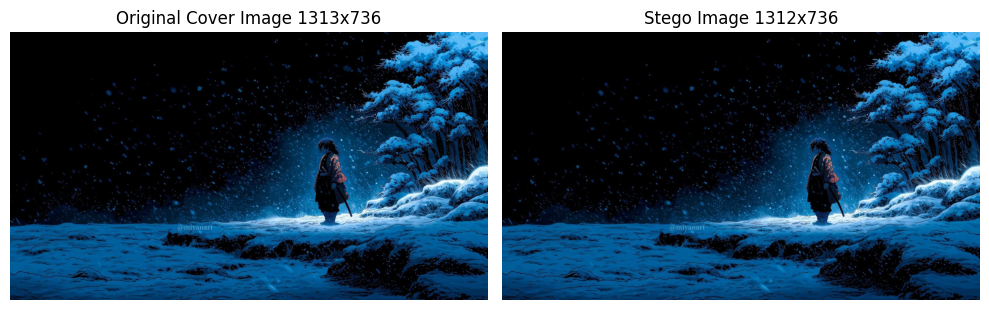

PSNR: 55.03 dB  (> 40 dB means distortion is imperceptible)


In [31]:
# ============================================================
# BLOCK 8 (v2): Visual comparison - handles cropped stego image
# ============================================================

cover = cv2.cvtColor(cv2.imread(COVER_IMAGE_PATH), cv2.COLOR_BGR2RGB)
stego_display = cv2.cvtColor(cv2.imread(STEGO_IMAGE_PATH), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(cover)
axes[0].set_title(f'Original Cover Image {cover.shape[1]}x{cover.shape[0]}')
axes[0].axis('off')

axes[1].imshow(stego_display)
axes[1].set_title(f'Stego Image {stego_display.shape[1]}x{stego_display.shape[0]}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Crop cover to same size as stego before PSNR calculation
h, w = stego_display.shape[:2]
cover_cropped = cover[0:h, 0:w]

mse = np.mean((cover_cropped.astype(float) - stego_display.astype(float)) ** 2)
if mse == 0:
    print('PSNR: Infinity (images are identical)')
else:
    psnr = 10 * np.log10((255 ** 2) / mse)
    print(f'PSNR: {psnr:.2f} dB  (> 40 dB means distortion is imperceptible)')

In [32]:
# CHARACTER COMPARISON BLOCK
extracted = extract_message(STEGO_IMAGE_PATH)

print(f'Original : "{SECRET_MESSAGE}"')
print(f'Extracted: "{extracted}"')
print()
print('Character by character:')
for i, (o, e) in enumerate(zip(SECRET_MESSAGE, extracted)):
    status = 'OK' if o == e else f'WRONG  expected={repr(o)} got={repr(e)}'
    print(f'  [{i:3d}] {status}')

if len(extracted) != len(SECRET_MESSAGE):
    print(f'\nLength mismatch! original={len(SECRET_MESSAGE)}, extracted={len(extracted)}')

Original : "Hello, this is a secret message hidden with DCT and i am shoyo trying to hide that from must"
Extracted: "Hello, this is a secret message hidden with DCT and i am shoyo trying to hide that from must"

Character by character:
  [  0] OK
  [  1] OK
  [  2] OK
  [  3] OK
  [  4] OK
  [  5] OK
  [  6] OK
  [  7] OK
  [  8] OK
  [  9] OK
  [ 10] OK
  [ 11] OK
  [ 12] OK
  [ 13] OK
  [ 14] OK
  [ 15] OK
  [ 16] OK
  [ 17] OK
  [ 18] OK
  [ 19] OK
  [ 20] OK
  [ 21] OK
  [ 22] OK
  [ 23] OK
  [ 24] OK
  [ 25] OK
  [ 26] OK
  [ 27] OK
  [ 28] OK
  [ 29] OK
  [ 30] OK
  [ 31] OK
  [ 32] OK
  [ 33] OK
  [ 34] OK
  [ 35] OK
  [ 36] OK
  [ 37] OK
  [ 38] OK
  [ 39] OK
  [ 40] OK
  [ 41] OK
  [ 42] OK
  [ 43] OK
  [ 44] OK
  [ 45] OK
  [ 46] OK
  [ 47] OK
  [ 48] OK
  [ 49] OK
  [ 50] OK
  [ 51] OK
  [ 52] OK
  [ 53] OK
  [ 54] OK
  [ 55] OK
  [ 56] OK
  [ 57] OK
  [ 58] OK
  [ 59] OK
  [ 60] OK
  [ 61] OK
  [ 62] OK
  [ 63] OK
  [ 64] OK
  [ 65] OK
  [ 66] OK
  [ 67] OK
  [ 68] OK
  [ 

In [33]:
# JSTEG DIAGNOSTIC
img = cv2.imread(COVER_IMAGE_PATH)
img = np.clip(img, 0, 255).astype(np.uint8)
h, w = img.shape[:2]
img = img[0:(h//8)*8, 0:(w//8)*8]

img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(img_ycrcb)
Y = Y.astype(np.float64)

# Take one non-flat block
block = Y[40:48, 40:48].copy()
print("Original block pixels:")
print(block.astype(int))

dct_b = apply_dct_block(block)
Q = JPEG_QUANT_TABLE[1, 1]  # position (1,1), Q=12

coeff_orig = dct_b[1, 1]
quant_orig = int(round(coeff_orig / Q))
print(f"\nOriginal coeff at (1,1): {coeff_orig:.4f}")
print(f"Quantized index        : {quant_orig}  ({'odd' if abs(quant_orig)%2==1 else 'even'})")

# Embed bit=1
dct_b[1, 1] = embed_bit_jsteg(coeff_orig, 1, Q)
coeff_embedded = dct_b[1, 1]
quant_embedded = int(round(coeff_embedded / Q))
print(f"\nAfter embedding bit=1  : {coeff_embedded:.4f}")
print(f"Quantized index        : {quant_embedded}  ({'odd' if abs(quant_embedded)%2==1 else 'even'})")

# IDCT -> uint8 -> reload -> DCT
restored_pixels = np.clip(apply_idct_block(dct_b), 0, 255).astype(np.uint8)
print(f"\nRestored pixels (uint8):")
print(restored_pixels)

# Re-apply DCT on the uint8 pixels
dct_after = apply_dct_block(restored_pixels.astype(np.float64))
coeff_after = dct_after[1, 1]
quant_after = int(round(coeff_after / Q))
print(f"\nCoeff after uint8 round-trip: {coeff_after:.4f}")
print(f"Quantized index             : {quant_after}  ({'odd' if abs(quant_after)%2==1 else 'even'})")
print(f"\nBit survived uint8 round-trip? {'YES' if abs(quant_after)%2 == 1 else 'NO'}")

# JPEGIO DIRECT DIAGNOSTIC
import jpegio
import numpy as np

# Step 1: Read the stego JPEG coefficients
jpeg_struct = jpegio.read(STEGO_IMAGE_PATH)
coeff_matrix = jpeg_struct.coef_arrays[0]

print("Stego coeff matrix shape:", coeff_matrix.shape)
print("Stego coeff dtype:", coeff_matrix.dtype)
print("\nFirst 5x5 of coefficients:")
print(coeff_matrix[:5, :5])

# Step 2: Manually extract first 16 bits and show them
bits = []
rows, cols = coeff_matrix.shape
count = 0
print("\nFirst 32 usable coefficients and their LSBs:")
for r in range(rows):
    for c in range(cols):
        val = int(coeff_matrix[r, c])
        if val in SKIP_VALUES:
            continue
        lsb = abs(val) % 2
        bits.append(lsb)
        print(f"  [{r},{c}] coeff={val:6d}  LSB={lsb}")
        count += 1
        if count >= 32:
            break
    if count >= 32:
        break

# Step 3: Decode first 4 characters from those bits
print("\nFirst 32 bits:", bits)
for i in range(0, 32, 8):
    byte_bits = bits[i:i+8]
    val = int(''.join(str(b) for b in byte_bits), 2)
    print(f"Bits {i}-{i+7}: {byte_bits} -> value={val} -> char={repr(chr(val))}")

# Step 4: Check what the ORIGINAL cover image coefficients look like
temp = '_diag_cover.jpg'
import cv2
img = cv2.imread(COVER_IMAGE_PATH)
cv2.imwrite(temp, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
cover_struct = jpegio.read(temp)
cover_coeff = cover_struct.coef_arrays[0]
import os
os.remove(temp)

print("\nCover coeff first 5x5:")
print(cover_coeff[:5, :5])

print("\nDifference between stego and cover (first 5x5):")
print(coeff_matrix[:5, :5] - cover_coeff[:5, :5])

# Step 5: Check first character of message in bits
expected_bits = text_to_bits(SECRET_MESSAGE[0])
print(f"\nExpected bits for '{SECRET_MESSAGE[0]}': {expected_bits}")

Original block pixels:
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


NameError: name 'JPEG_QUANT_TABLE' is not defined

In [34]:
# ============================================================
# BLOCK 9: EXTRACT the hidden message from the stego image
# ============================================================

recovered = extract_message(STEGO_IMAGE_PATH)

print(f'Extracted message: "{recovered}"')
print()
if recovered == SECRET_MESSAGE:
    print('SUCCESS: Extracted message matches the original!')
else:
    print('WARNING: Messages do not match. Check QUANTIZATION_STEP or image compression.')

Extracted message: "Hello, this is a secret message hidden with DCT and i am shoyo trying to hide that from must"

SUCCESS: Extracted message matches the original!


In [35]:
# ============================================================
# BLOCK 10: Attack functions
# Each function takes the stego image path, applies an attack,
# saves the attacked image, and returns the saved path.
# ============================================================
import cv2
import numpy as np
import os

# --- Helper: calculate PSNR between original stego and attacked version ---
def calc_psnr(img1_path, img2_path):
    """
    Peak Signal-to-Noise Ratio between two images.
    Higher = less visual distortion.
    > 40 dB = imperceptible to humans.
    """
    a = cv2.imread(img1_path).astype(np.float64)
    b = cv2.imread(img2_path).astype(np.float64)

    # Crop both to same size in case of size mismatch after attack
    h = min(a.shape[0], b.shape[0])
    w = min(a.shape[1], b.shape[1])
    a, b = a[:h, :w], b[:h, :w]

    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((255 ** 2) / mse)


# --- Helper: compare extracted message to original ---
def evaluate(extracted, original):
    """
    Returns (survived, corrupted_chars, total_chars)
    survived       : True if message extracted perfectly
    corrupted_chars: number of wrong characters
    total_chars    : length of original message
    """
    total = len(original)
    if not extracted:
        return False, total, total
    corrupted = sum(1 for a, b in zip(original, extracted) if a != b)
    corrupted += abs(len(original) - len(extracted))  # length difference counts too
    survived = (corrupted == 0)
    return survived, corrupted, total


# ============================================================
# ATTACK 1: JPEG Compression
# Saves the stego image as JPEG at different quality levels
# then reloads it as PNG. This is the most destructive attack
# because JPEG re-quantizes DCT coefficients.
# ============================================================
def attack_jpeg(stego_path, quality, output_path):
    img = cv2.imread(stego_path)
    # Save as JPEG with the given quality (100=best, 1=worst)
    temp_jpg = output_path.replace('.png', '_temp.jpg')
    cv2.imwrite(temp_jpg, img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    # Reload the JPEG and save back as PNG for extraction
    reloaded = cv2.imread(temp_jpg)
    cv2.imwrite(output_path, reloaded)
    os.remove(temp_jpg)  # clean up temp file
    return output_path


# ============================================================
# ATTACK 2: Gaussian Noise
# Adds random pixel noise sampled from a Gaussian distribution.
# Simulates a noisy transmission channel.
# ============================================================
def attack_gaussian_noise(stego_path, std, output_path):
    img = cv2.imread(stego_path).astype(np.float64)
    # Generate noise with mean=0 and the given standard deviation
    noise = np.random.normal(0, std, img.shape)
    noisy = np.clip(img + noise, 0, 255).astype(np.uint8)
    cv2.imwrite(output_path, noisy)
    return output_path


# ============================================================
# ATTACK 3: Resizing
# Scales the image down then back up to original size.
# Interpolation during resize changes pixel values.
# ============================================================
def attack_resize(stego_path, scale_factor, output_path):
    img = cv2.imread(stego_path)
    h, w = img.shape[:2]
    # Scale down
    small_w = int(w * scale_factor)
    small_h = int(h * scale_factor)
    small = cv2.resize(img, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
    # Scale back up to original size
    restored = cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(output_path, restored)
    return output_path


# ============================================================
# ATTACK 4: Rotation
# Rotates the image by a small angle then rotates back.
# Even tiny rotations desync the 8x8 block grid.
# ============================================================
def attack_rotation(stego_path, angle, output_path):
    img = cv2.imread(stego_path)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    # Rotate by +angle
    M_fwd = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M_fwd, (w, h),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REFLECT)
    # Rotate back by -angle
    M_back = cv2.getRotationMatrix2D(center, -angle, 1.0)
    restored = cv2.warpAffine(rotated, M_back, (w, h),
                               flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_REFLECT)
    cv2.imwrite(output_path, restored)
    return output_path


# ============================================================
# ATTACK 5: Histogram Equalization
# Redistributes pixel intensity values to improve contrast.
# Drastically changes the Y channel — very destructive.
# ============================================================
def attack_histogram_eq(stego_path, output_path):
    img = cv2.imread(stego_path)
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(img_ycrcb)
    # Equalize only the Y channel (same channel we embed into)
    Y_eq = cv2.equalizeHist(Y)
    merged = cv2.merge([Y_eq, Cr, Cb])
    result = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(output_path, result)
    return output_path


# ============================================================
# ATTACK 6: Median Filter
# Replaces each pixel with the median of its neighbors.
# Commonly used to remove noise — also removes hidden data.
# ============================================================
def attack_median_filter(stego_path, kernel_size, output_path):
    img = cv2.imread(stego_path)
    # kernel_size must be odd: 3, 5, 7...
    filtered = cv2.medianBlur(img, kernel_size)
    cv2.imwrite(output_path, filtered)
    return output_path


print('All attack functions defined.')

All attack functions defined.


In [36]:
# ============================================================
# BLOCK 11: Run all attacks and collect results
# ============================================================
import os

# Make a folder to store attacked images
ATTACK_DIR = 'attacked_images'
os.makedirs(ATTACK_DIR, exist_ok=True)

# All attacks to run with their parameters
# Format: (attack_name, function_call_lambda, output_filename)
attacks = [
    # JPEG at different quality levels
    ('JPEG Quality=90',  lambda: attack_jpeg(STEGO_IMAGE_PATH, 90,  f'{ATTACK_DIR}/jpeg_q90.png')),
    ('JPEG Quality=75',  lambda: attack_jpeg(STEGO_IMAGE_PATH, 75,  f'{ATTACK_DIR}/jpeg_q75.png')),
    ('JPEG Quality=50',  lambda: attack_jpeg(STEGO_IMAGE_PATH, 50,  f'{ATTACK_DIR}/jpeg_q50.png')),

    # Gaussian noise at different intensities
    ('Gaussian Noise std=5',  lambda: attack_gaussian_noise(STEGO_IMAGE_PATH, 5,  f'{ATTACK_DIR}/noise_5.png')),
    ('Gaussian Noise std=15', lambda: attack_gaussian_noise(STEGO_IMAGE_PATH, 15, f'{ATTACK_DIR}/noise_15.png')),
    ('Gaussian Noise std=30', lambda: attack_gaussian_noise(STEGO_IMAGE_PATH, 30, f'{ATTACK_DIR}/noise_30.png')),

    # Resizing at different scale factors
    ('Resize scale=0.9', lambda: attack_resize(STEGO_IMAGE_PATH, 0.9, f'{ATTACK_DIR}/resize_90.png')),
    ('Resize scale=0.75',lambda: attack_resize(STEGO_IMAGE_PATH, 0.75,f'{ATTACK_DIR}/resize_75.png')),
    ('Resize scale=0.5', lambda: attack_resize(STEGO_IMAGE_PATH, 0.5, f'{ATTACK_DIR}/resize_50.png')),

    # Rotation at different angles
    ('Rotation 1 deg',   lambda: attack_rotation(STEGO_IMAGE_PATH, 1,  f'{ATTACK_DIR}/rot_1.png')),
    ('Rotation 5 deg',   lambda: attack_rotation(STEGO_IMAGE_PATH, 5,  f'{ATTACK_DIR}/rot_5.png')),
    ('Rotation 10 deg',  lambda: attack_rotation(STEGO_IMAGE_PATH, 10, f'{ATTACK_DIR}/rot_10.png')),

    # Histogram equalization
    ('Histogram EQ',     lambda: attack_histogram_eq(STEGO_IMAGE_PATH, f'{ATTACK_DIR}/histeq.png')),

    # Median filter at different kernel sizes
    ('Median Filter k=3',lambda: attack_median_filter(STEGO_IMAGE_PATH, 3, f'{ATTACK_DIR}/median_3.png')),
    ('Median Filter k=5',lambda: attack_median_filter(STEGO_IMAGE_PATH, 5, f'{ATTACK_DIR}/median_5.png')),
]

# Run each attack and collect results
results = []

print(f'Running {len(attacks)} attacks...\n')
print(f'{"Attack":<25} {"Survived":<10} {"Corrupted":<15} {"PSNR (dB)":<12}')
print('-' * 65)

for attack_name, attack_fn in attacks:
    try:
        # Apply the attack
        attacked_path = attack_fn()

        # Try to extract the message from the attacked image
        extracted = extract_message(attacked_path)

        # Evaluate how well the message survived
        survived, corrupted, total = evaluate(extracted, SECRET_MESSAGE)

        # Calculate PSNR between original stego and attacked version
        psnr = calc_psnr(STEGO_IMAGE_PATH, attacked_path)
        psnr_str = f'{psnr:.2f}' if psnr != float('inf') else 'inf'

        # Store result
        results.append({
            'name': attack_name,
            'survived': survived,
            'corrupted': corrupted,
            'total': total,
            'psnr': psnr,
            'psnr_str': psnr_str,
            'extracted': extracted,
            'path': attacked_path
        })

        status = 'YES ✓' if survived else 'NO  ✗'
        corrupted_str = f'{corrupted}/{total} chars'
        print(f'{attack_name:<25} {status:<10} {corrupted_str:<15} {psnr_str:<12}')

    except Exception as e:
        print(f'{attack_name:<25} ERROR: {e}')
        results.append({'name': attack_name, 'survived': False,
                        'corrupted': -1, 'total': len(SECRET_MESSAGE),
                        'psnr': 0, 'psnr_str': 'N/A', 'extracted': '', 'path': ''})

print('-' * 65)
survived_count = sum(1 for r in results if r['survived'])
print(f'\nMessage survived {survived_count}/{len(results)} attacks.')

Running 15 attacks...

Attack                    Survived   Corrupted       PSNR (dB)   
-----------------------------------------------------------------
JPEG Quality=90           NO  ✗      92/92 chars     43.61       
JPEG Quality=75           NO  ✗      92/92 chars     38.84       
JPEG Quality=50           NO  ✗      92/92 chars     32.40       
Gaussian Noise std=5      NO  ✗      21/92 chars     35.57       
Gaussian Noise std=15     NO  ✗      81/92 chars     26.21       
Gaussian Noise std=30     NO  ✗      90/92 chars     20.38       
Resize scale=0.9          NO  ✗      3/92 chars      34.22       
Resize scale=0.75         NO  ✗      3/92 chars      33.01       
Resize scale=0.5          NO  ✗      49/92 chars     30.37       
Rotation 1 deg            NO  ✗      9/92 chars      33.91       
Rotation 5 deg            NO  ✗      33/92 chars     26.97       
Rotation 10 deg           NO  ✗      37/92 chars     23.30       
Histogram EQ              NO  ✗      5/92 chars      

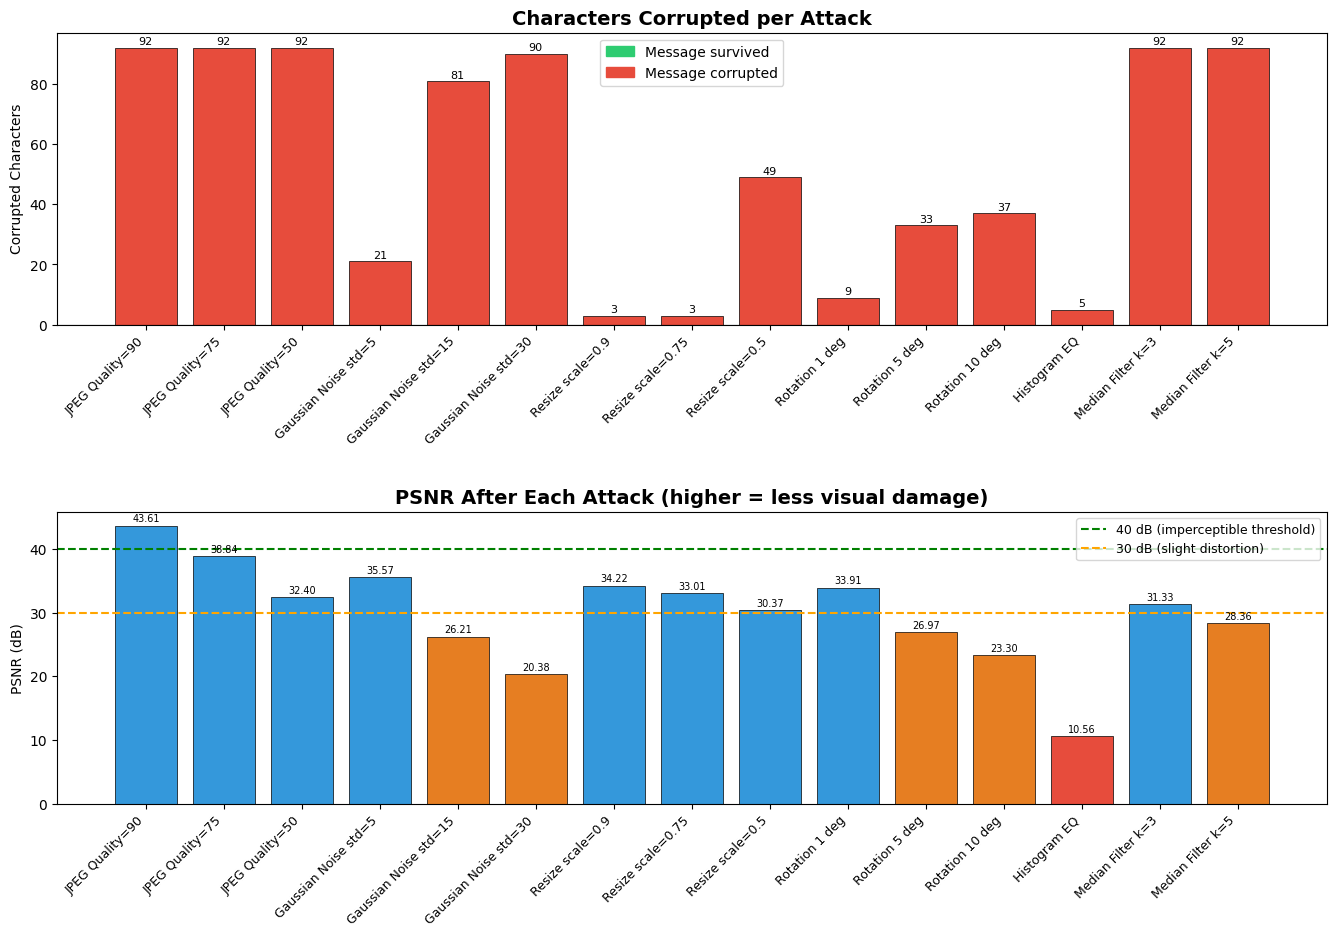

Chart saved as attack_results.png

===== FULL RESULTS SUMMARY =====
Attack                    Survived   Corrupted       PSNR       Extracted message
JPEG Quality=90           NO         92/92           43.61      ''
JPEG Quality=75           NO         92/92           38.84      ''
JPEG Quality=50           NO         92/92           32.40      ''
Gaussian Noise std=5      NO         21/92           35.57      'Helho< this is a(secret$ma3sage Hidden w...'
Gaussian Noise std=15     NO         81/92           26.21      'áEjü\x7fn0pHióP1\x17\x0c!Hqec|&4$½d{£\x15bÄ\x04i+TdmO\xa0w...'
Gaussian Noise std=30     NO         90/92           20.38      '[1Í\x06j<\x84d1ëö\x01Kq¢Ý*%\x07s6#\x19ñdmù2õìd/jàl@;5 3...'
Resize scale=0.9          NO         3/92            34.22      'Hello, this is a secret message hidden$w...'
Resize scale=0.75         NO         3/92            33.01      'Hello, this is a sEcret message hidden w...'
Resize scale=0.5          NO         49/92           30.37      'ÿ

In [37]:
# ============================================================
# BLOCK 12: Visualize results
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# --- Chart 1: Corrupted characters per attack ---
names      = [r['name'] for r in results]
corrupted  = [r['corrupted'] for r in results]
survived   = [r['survived'] for r in results]
psnr_vals  = [r['psnr'] if r['psnr'] != float('inf') else 60 for r in results]
colors     = ['#2ecc71' if s else '#e74c3c' for s in survived]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Bar chart — corrupted characters
bars = axes[0].bar(names, corrupted, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_title('Characters Corrupted per Attack', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Corrupted Characters')
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[0].axhline(y=0, color='black', linewidth=0.8)
axes[0].set_ylim(0, len(SECRET_MESSAGE) + 5)

# Add value labels on bars
for bar, val in zip(bars, corrupted):
    if val > 0:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                     str(val), ha='center', va='bottom', fontsize=8)

# Legend
green_patch = mpatches.Patch(color='#2ecc71', label='Message survived')
red_patch   = mpatches.Patch(color='#e74c3c', label='Message corrupted')
axes[0].legend(handles=[green_patch, red_patch])

# Bar chart — PSNR values
psnr_colors = ['#3498db' if p >= 30 else '#e67e22' if p >= 20 else '#e74c3c'
               for p in psnr_vals]
bars2 = axes[1].bar(names, psnr_vals, color=psnr_colors, edgecolor='black', linewidth=0.5)
axes[1].set_title('PSNR After Each Attack (higher = less visual damage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[1].axhline(y=40, color='green', linewidth=1.5, linestyle='--', label='40 dB (imperceptible threshold)')
axes[1].axhline(y=30, color='orange', linewidth=1.5, linestyle='--', label='30 dB (slight distortion)')
axes[1].legend(fontsize=9)

# Add PSNR value labels
for bar, val, r in zip(bars2, psnr_vals, results):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 r['psnr_str'], ha='center', va='bottom', fontsize=7)

plt.tight_layout(pad=3.0)
plt.savefig('attack_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Chart saved as attack_results.png')

# --- Summary table ---
print('\n===== FULL RESULTS SUMMARY =====')
print(f'{"Attack":<25} {"Survived":<10} {"Corrupted":<15} {"PSNR":<10} {"Extracted message"}')
print('=' * 100)
for r in results:
    status   = 'YES' if r['survived'] else 'NO'
    corrupt  = f"{r['corrupted']}/{r['total']}" if r['corrupted'] >= 0 else 'ERROR'
    preview  = r['extracted'][:40] + '...' if len(r['extracted']) > 40 else r['extracted']
    print(f"{r['name']:<25} {status:<10} {corrupt:<15} {r['psnr_str']:<10} {repr(preview)}")

# --- What each attack means ---
print('''
===== WHAT THE RESULTS MEAN =====

JPEG Compression:
  JPEG re-quantizes DCT blocks — the most destructive attack for DCT steganography.
  Our method embeds using coefficient COMPARISON (A vs B), not exact values,
  so it has some resistance but JPEG at low quality will likely still break it.

Gaussian Noise:
  Random pixel changes. Low noise (std=5) may survive because our DELTA gap
  is larger than the noise. High noise (std=30) flips too many coefficients.

Resizing:
  Interpolation completely rearranges pixel values — block grid is destroyed.
  Even 90% scale is usually fatal for block-based steganography.

Rotation:
  Even 1 degree misaligns all 8x8 blocks — almost always fatal.
  This is a known fundamental weakness of DCT steganography.

Histogram Equalization:
  Stretches pixel intensities — massively changes the Y channel we embed into.
  Almost always destroys the hidden message.

Median Filter:
  Smoothing filter removes high and mid frequency changes — our embedded
  coefficients are mid-frequency so small kernels (3x3) may partially survive.
''')